In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

In [8]:
import requests
from pathlib import Path

def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.
    
    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded 
    
    return: The pathlib.Path to the file.
    """
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True)
    file_path = data_dir/Path(file)
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
    else:
        import time 
        created = time.ctime(file_path.stat().st_ctime)
        print("Using cached version downloaded at", created)
    return file_path

In [9]:
data_url = 'https://www.ssa.gov/oact/babynames/state/namesbystate.zip'
namesbystate_path = fetch_and_cache(data_url, 'namesbystate.zip')

Using cached version downloaded at Tue Apr 19 13:28:02 2022


In [10]:
import zipfile
zf = zipfile.ZipFile(namesbystate_path, 'r')

column_labels = ['State', 'Sex', 'Year', 'Name', 'Count']

def load_dataframe_from_zip(zf, f):
    with zf.open(f) as fh: 
        return pd.read_csv(fh, header=None, names=column_labels)

states = [
    load_dataframe_from_zip(zf, f)
    for f in sorted(zf.filelist, key=lambda x:x.filename) 
    if f.filename.endswith('.TXT')
]

baby_names = states[0]
for state_df in states[1:]:
    baby_names = pd.concat([baby_names, state_df])
baby_names = baby_names.reset_index().iloc[:, 1:]

In [11]:
baby_names_year = baby_names.groupby(['Name', 'Year', 'Sex']).sum().reset_index()
baby_names_year

,Name,Year,Sex,Count
0,Aaban,2013,M,6
1,Aaban,2014,M,6
2,Aadam,2019,M,6
3,Aadan,2008,M,12
4,Aadan,2009,M,6
...,...,...,...,...
642565,Zyriah,2013,F,7
642566,Zyriah,2014,F,6
642567,Zyriah,2016,F,5
642568,Zyron,2015,M,5


In [12]:
engine.execute('DROP TABLE IF EXISTS baby')

In [13]:
baby_names_year.to_sql('baby', con=engine)

642570

In [14]:
engine.execute("SELECT * FROM baby").fetchall()

[(0, 'Aaban', 2013, 'M', 6),
 (1, 'Aaban', 2014, 'M', 6),
 (2, 'Aadam', 2019, 'M', 6),
 (3, 'Aadan', 2008, 'M', 12),
 (4, 'Aadan', 2009, 'M', 6),
 (5, 'Aadan', 2014, 'M', 5),
 (6, 'Aadarsh', 2009, 'M', 5),
 (7, 'Aadarsh', 2019, 'M', 6),
 (8, 'Aaden', 2005, 'M', 5),
 (9, 'Aaden', 2007, 'M', 98),
 (10, 'Aaden', 2008, 'M', 940),
 (11, 'Aaden', 2009, 'M', 1242),
 (12, 'Aaden', 2010, 'M', 414),
 (13, 'Aaden', 2011, 'M', 229),
 (14, 'Aaden', 2012, 'M', 167),
 (15, 'Aaden', 2013, 'M', 155),
 (16, 'Aaden', 2014, 'M', 186),
 (17, 'Aaden', 2015, 'M', 248),
 (18, 'Aaden', 2016, 'M', 128),
 (19, 'Aaden', 2017, 'M', 197),
 (20, 'Aaden', 2018, 'M', 105),
 (21, 'Aaden', 2019, 'M', 43),
 (22, 'Aaden', 2020, 'M', 15),
 (23, 'Aadhav', 2014, 'M', 6),
 (24, 'Aadhav', 2015, 'M', 14),
 (25, 'Aadhav', 2016, 'M', 5),
 (26, 'Aadhav', 2017, 'M', 12),
 (27, 'Aadhav', 2019, 'M', 6),
 (28, 'Aadhira', 2017, 'F', 11),
 (29, 'Aadhira', 2018, 'F', 15),
 (30, 'Aadhira', 2020, 'F', 6),
 (31, 'Aadhvik', 2019, 'M', 5),
 (

In [31]:
engine.execute("Select Year, Sex, MAC(Count)").fetchall()

[(10446,)]

In [15]:
engine.execute("SELECT * FROM baby WHERE Name = 'Michael' AND Sex = 'M'").fetchall()

[(440142, 'Michael', 1910, 'M', 795),
 (440143, 'Michael', 1911, 'M', 1114),
 (440144, 'Michael', 1912, 'M', 2068),
 (440145, 'Michael', 1913, 'M', 2566),
 (440146, 'Michael', 1914, 'M', 3314),
 (440147, 'Michael', 1915, 'M', 4045),
 (440148, 'Michael', 1916, 'M', 4181),
 (440149, 'Michael', 1917, 'M', 4257),
 (440150, 'Michael', 1918, 'M', 4259),
 (440152, 'Michael', 1919, 'M', 3891),
 (440154, 'Michael', 1920, 'M', 3977),
 (440156, 'Michael', 1921, 'M', 4170),
 (440158, 'Michael', 1922, 'M', 3979),
 (440160, 'Michael', 1923, 'M', 3892),
 (440162, 'Michael', 1924, 'M', 3862),
 (440164, 'Michael', 1925, 'M', 3745),
 (440166, 'Michael', 1926, 'M', 3464),
 (440168, 'Michael', 1927, 'M', 3583),
 (440170, 'Michael', 1928, 'M', 3573),
 (440172, 'Michael', 1929, 'M', 3432),
 (440174, 'Michael', 1930, 'M', 3514),
 (440176, 'Michael', 1931, 'M', 3468),
 (440177, 'Michael', 1932, 'M', 3593),
 (440178, 'Michael', 1933, 'M', 3533),
 (440180, 'Michael', 1934, 'M', 4092),
 (440181, 'Michael', 1935,

In [24]:
name_dataframe = pd.read_sql("SELECT * FROM baby WHERE Name = 'Michael' AND Sex = 'M'", engine)
name_dataframe

,index,Name,Year,Sex,Count
0,440142,Michael,1910,M,795
1,440143,Michael,1911,M,1114
2,440144,Michael,1912,M,2068
3,440145,Michael,1913,M,2566
4,440146,Michael,1914,M,3314
...,...,...,...,...,...
106,440339,Michael,2016,M,14103
107,440340,Michael,2017,M,12669
108,440341,Michael,2018,M,11698
109,440342,Michael,2019,M,10558


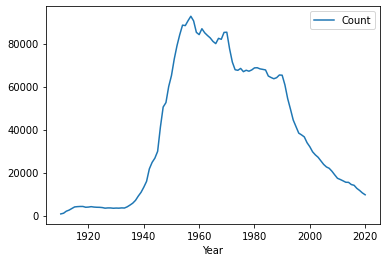

In [27]:
ax = name_dataframe.plot(x='Year', y='Count', kind='line')
#ax.set_ylabel('Occurrences')
#ax.set_xlabel('Year')
#ax.set_title('Title')
plt.show()

In [32]:
engine.execute('SELECT Year, Sex, MAX(Count), MAX(Name) FROM baby GROUP BY Year, Sex').fetchall()

[(1910, 'F', 22848, 'Zula'),
 (1910, 'M', 11450, 'Zennie'),
 (1911, 'F', 24390, 'Zula'),
 (1911, 'M', 13446, 'Zeb'),
 (1912, 'F', 32304, 'Zula'),
 (1912, 'M', 24587, 'Zollie'),
 (1913, 'F', 36642, 'Zula'),
 (1913, 'M', 29329, 'Zigmund'),
 (1914, 'F', 45345, 'Zula'),
 (1914, 'M', 37948, 'Zygmunt'),
 (1915, 'F', 58187, 'Zulema'),
 (1915, 'M', 47576, 'Zygmunt'),
 (1916, 'F', 61438, 'Zulema'),
 (1916, 'M', 50043, 'Zygmunt'),
 (1917, 'F', 64280, 'Zulema'),
 (1917, 'M', 51852, 'Zygmunt'),
 (1918, 'F', 67366, 'Zuma'),
 (1918, 'M', 56559, 'Zygmunt'),
 (1919, 'F', 65838, 'Zulema'),
 (1919, 'M', 53526, 'Zygmunt'),
 (1920, 'F', 70982, 'Zulema'),
 (1920, 'M', 56914, 'Zygmunt'),
 (1921, 'F', 73985, 'Zulema'),
 (1921, 'M', 58215, 'Zolton'),
 (1922, 'F', 72176, 'Zulema'),
 (1922, 'M', 57280, 'Zoltan'),
 (1923, 'F', 71635, 'Zulema'),
 (1923, 'M', 57469, 'Zollie'),
 (1924, 'F', 73536, 'Zulema'),
 (1924, 'M', 60801, 'Zoltan'),
 (1925, 'F', 70586, 'Zulema'),
 (1925, 'M', 60897, 'Zollie'),
 (1926, 'F', 67

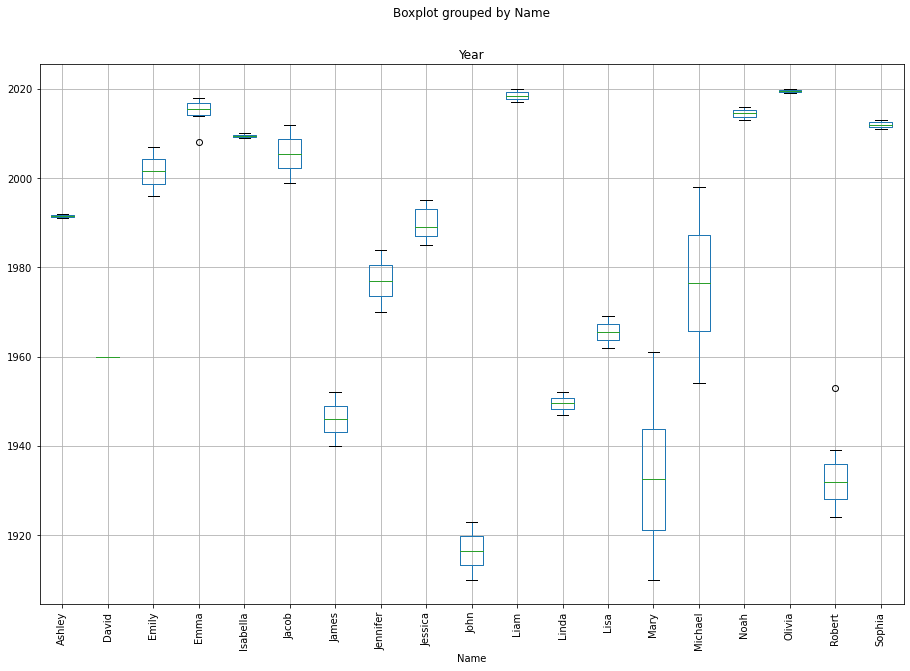

In [14]:
common_names = pd.read_sql('SELECT Year, Sex, MAX(Count), Name FROM baby GROUP BY Year, Sex', engine)
common_names.head()
common_names.boxplot(by='Name', column='Year', rot=90, figsize=(15,10));

In [41]:
baby_popular = pd.read_sql("SELECT MAX(Count), Name FROM baby WHERE Sex = 'M' AND Year = 1993", engine)
baby_popular

,MAX(Count),Name
0,49554,Michael
